# RGI-TOPO for RGI 7.0

OGGM was used to generate the topography data used to compute the topographical attributes and the centerlines products for RGI v7.0.

Here we show how to access this data from OGGM.

## Input parameters 

This notebook can be run as a script with parameters using [papermill](https://github.com/nteract/papermill), but it is not necessary. The following cell contains the parameters you can choose from:

In [1]:
# The RGI Id of the glaciers you want to look for
# Use the original shapefiles or the GLIMS viewer to check for the ID: https://www.glims.org/maps/glims
rgi_id = 'RGI2000-v7.0-G-01-06486'  # Denali

# The default is to test for all sources available for this glacier
# Set to a list of source names to override this
sources = None
# Where to write the plots. Default is in the current working directory
plot_dir = f'outputs/{rgi_id}'
# The RGI version to use
# V62 is an unofficial modification of V6 with only minor, backwards compatible modifications
prepro_rgi_version = 62
# Size of the map around the glacier. Currently only 10 and 40 are available
prepro_border = 10
# Degree of processing level.  Currently only 1 is available.
from_prepro_level = 1

## Check input and set up

In [2]:
# The sources can be given as parameters
if sources is not None and isinstance(sources, str):
    sources = sources.split(',')

In [3]:
# Plotting directory as well
if not plot_dir:
    plot_dir = './' + rgi_id
import os
plot_dir = os.path.abspath(plot_dir)

In [6]:
from oggm import cfg, utils, workflow, tasks, graphics, GlacierDirectory
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
import salem
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import itertools

from oggm.utils import DEM_SOURCES
from oggm.workflow import init_glacier_directories

In [7]:
# Make sure the plot directory exists
utils.mkdir(plot_dir);
# Use OGGM to download the data
cfg.initialize()
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-RGITOPO-RGI7', reset=True)
cfg.PARAMS['use_intersects'] = False

2024-04-30 11:13:04: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-04-30 11:13:04: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-04-30 11:13:04: oggm.cfg: Multiprocessing: using all available processors (N=12)
2024-04-30 11:13:07: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.


## Download the data using OGGM utility functions 

Note that you could reach the same goal by downloading the data manually from 

In [8]:
# URL of the preprocessed GDirs
gdir_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/rgitopo/2023.1/'
# We use OGGM to download the data
gdir = init_glacier_directories([rgi_id], from_prepro_level=1, prepro_border=10,  prepro_rgi_version='70', prepro_base_url=gdir_url)[0]

2024-04-30 11:13:07: oggm.workflow: init_glacier_directories from prepro level 1 on 1 glaciers.
2024-04-30 11:13:07: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-04-30 11:13:07: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/rgitopo/2023.1/RGI70/b_010/L1/RGI2000-v7.0-G-01/RGI2000-v7.0-G-01-06.tar to /home/leadu/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/rgitopo/2023.1/RGI70/b_010/L1/RGI2000-v7.0-G-01/RGI2000-v7.0-G-01-06.tar...
2024-04-30 11:13:13: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/~fmaussion/misc/rgi7_data/00_rgi70_regions/00_rgi70_O1Regions/00_rgi70_O1Regions.dbf to /home/leadu/OGGM/download_cache/cluster.klima.uni-bremen.de/~fmaussion/misc/rgi7_data/00_rgi70_regions/00_rgi70_O1Regions/00_rgi70_O1Regions.dbf...
2024-04-30 11:13:14: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/~fmaussion/misc/rgi7_data/00_rgi70_regions/00_rgi70_O2Regions/00_rgi70_O2Region

In [9]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI2000-v7.0-G-01-06486
  Region: 01: Alaska
  Subregion: 01-02: Alaska Range (Wrangell/Kilbuck)
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 0.961122833004822 km2
  Lon, Lat: (-151.0094740399913, 63.061062)
  Grid (nx, ny): (70, 88)
  Grid (dx, dy): (24.0, -24.0)

## Read the DEMs and store them all in a dataset 

In [10]:
if sources is None:
    sources = [src for src in os.listdir(gdir.dir) if src in utils.DEM_SOURCES]

In [11]:
print('RGI ID:', rgi_id)
print('Available DEM sources:', sources)
print('Plotting directory:', plot_dir)

RGI ID: RGI2000-v7.0-G-01-06486
Available DEM sources: ['COPDEM90', 'ARCTICDEM', 'MAPZEN', 'COPDEM30', 'ALASKA', 'TANDEM', 'ASTER', 'DEM3', 'AW3D30']
Plotting directory: /mnt/c/Users/leadu/Documents/INSA/INSA_4A/PLD-SMART/smart24/notebooks/outputs/RGI2000-v7.0-G-01-06486


In [12]:
# We use xarray to store the data
ods = xr.Dataset()
for src in sources:
    demfile = os.path.join(gdir.dir, src) + '/dem.tif'
    with rioxr.open_rasterio(demfile) as ds:
        data = ds.sel(band=1).load() * 1.
        ods[src] = data.where(data > -100, np.NaN)
    
    sy, sx = np.gradient(ods[src], gdir.grid.dx, gdir.grid.dx)
    ods[src + '_slope'] = ('y', 'x'),  np.arctan(np.sqrt(sy**2 + sx**2))

with rioxr.open_rasterio(gdir.get_filepath('glacier_mask')) as ds:
    ods['mask'] = ds.sel(band=1).load()

In [13]:
# Decide on the number of plots and figure size
ns = len(sources)
x_size = 12
n_cols = 3
n_rows = -(-ns // n_cols)
y_size = x_size / n_cols * n_rows

## Raw topography data 

ImportError: Needs scikit-image to be installed.

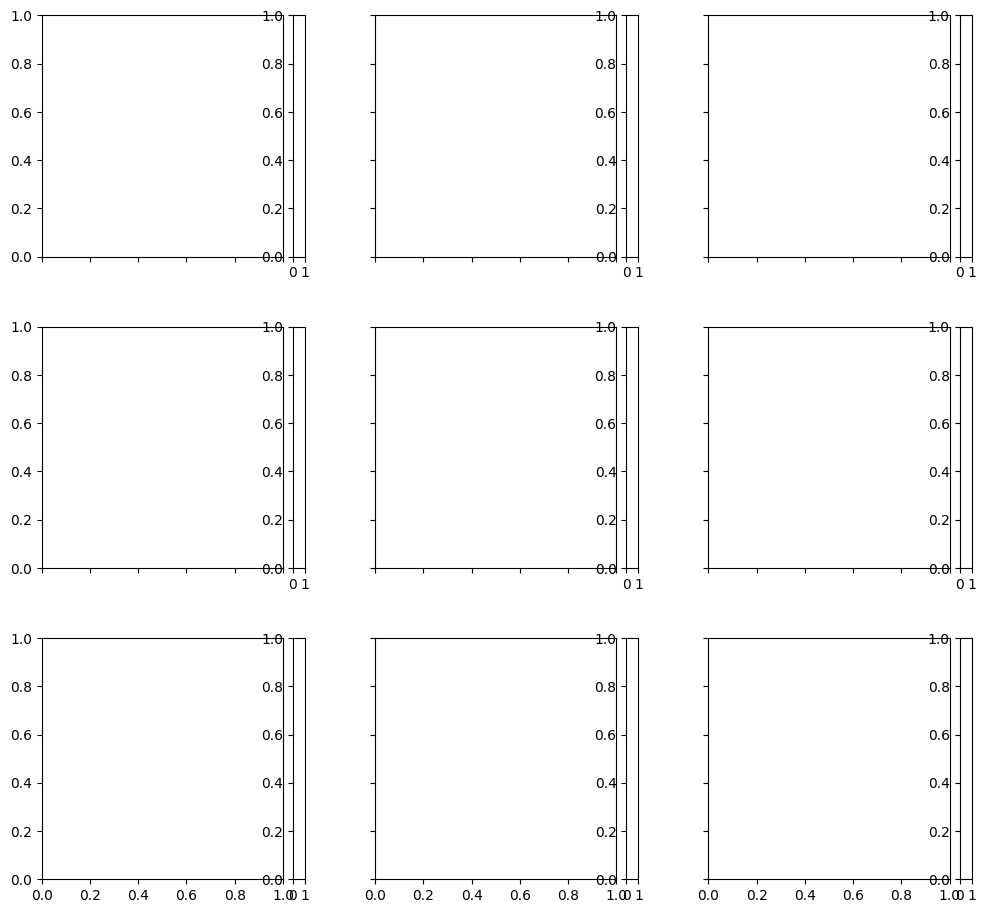

In [16]:
smap = salem.graphics.Map(gdir.grid, countries=False)
smap.set_shapefile(gdir.read_shapefile('outlines'))
smap.set_plot_params(cmap='topo')
smap.set_lonlat_contours(add_tick_labels=False)
smap.set_plot_params(vmin=np.nanquantile([ods[s].min() for s in sources], 0.25),
                     vmax=np.nanquantile([ods[s].max() for s in sources], 0.75))

fig = plt.figure(figsize=(x_size, y_size))
grid = AxesGrid(fig, 111,
                nrows_ncols=(n_rows, n_cols),
                axes_pad=0.7,
                cbar_mode='each',
                cbar_location='right',
                cbar_pad=0.1
                )

for i, s in enumerate(sources):
    data = ods[s]
    smap.set_data(data)
    ax = grid[i]
    smap.visualize(ax=ax, addcbar=False, title=s)
    if np.isnan(data).all():
        grid[i].cax.remove()
        continue
    cax = grid.cbar_axes[i]
    smap.colorbarbase(cax)
    
# take care of uneven grids
if ax != grid[-1] and not grid[-1].title.get_text():
    grid[-1].remove()
    grid[-1].cax.remove()
if ax != grid[-2] and not grid[-2].title.get_text():
    grid[-2].remove()
    grid[-2].cax.remove()

plt.savefig(os.path.join(plot_dir, 'dem_topo_color.png'), dpi=150, bbox_inches='tight')

## Shaded relief 

ImportError: Needs scikit-image to be installed.

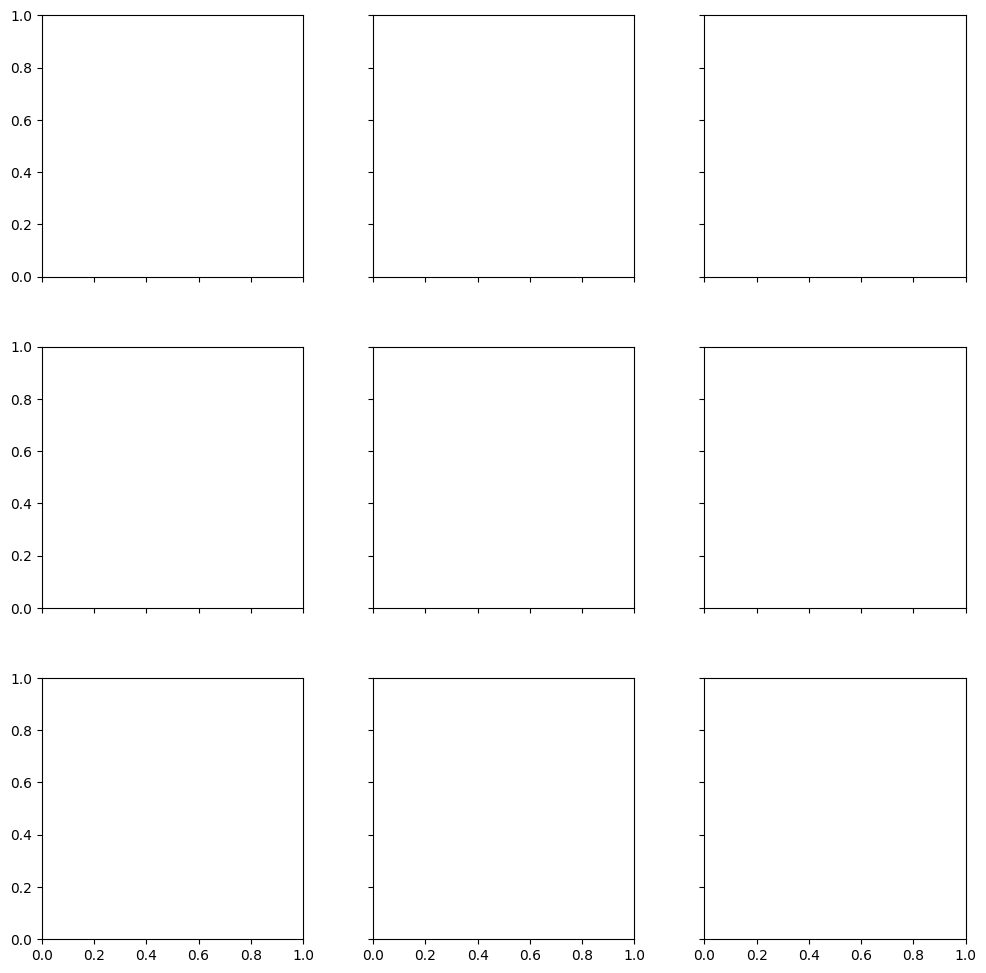

In [15]:
fig = plt.figure(figsize=(x_size, y_size))
grid = AxesGrid(fig, 111,
                nrows_ncols=(n_rows, n_cols),
                axes_pad=0.7,
                cbar_location='right',
                cbar_pad=0.1
                )
smap.set_plot_params(cmap='Blues')
smap.set_shapefile()
for i, s in enumerate(sources):
    data = ods[s].copy().where(np.isfinite(ods[s]), 0)
    smap.set_data(data * 0)
    ax = grid[i]
    smap.set_topography(data)
    smap.visualize(ax=ax, addcbar=False, title=s)
    
# take care of uneven grids
if ax != grid[-1] and not grid[-1].title.get_text():
    grid[-1].remove()
    grid[-1].cax.remove()
if ax != grid[-2] and not grid[-2].title.get_text():
    grid[-2].remove()
    grid[-2].cax.remove()

plt.savefig(os.path.join(plot_dir, 'dem_topo_shade.png'), dpi=150, bbox_inches='tight')

## Slope 

In [ ]:
fig = plt.figure(figsize=(x_size, y_size))
grid = AxesGrid(fig, 111,
                nrows_ncols=(n_rows, n_cols),
                axes_pad=0.7,
                cbar_mode='each',
                cbar_location='right',
                cbar_pad=0.1
                )

smap.set_topography();
smap.set_plot_params(vmin=0, vmax=0.7, cmap='Blues')

for i, s in enumerate(sources):
    data = ods[s + '_slope']
    smap.set_data(data)
    ax = grid[i]
    smap.visualize(ax=ax, addcbar=False, title=s + ' (slope)')
    cax = grid.cbar_axes[i]
    smap.colorbarbase(cax)
    
# take care of uneven grids
if ax != grid[-1] and not grid[-1].title.get_text():
    grid[-1].remove()
    grid[-1].cax.remove()
if ax != grid[-2] and not grid[-2].title.get_text():
    grid[-2].remove()
    grid[-2].cax.remove()

plt.savefig(os.path.join(plot_dir, 'dem_slope.png'), dpi=150, bbox_inches='tight')

## Some simple statistics about the DEMs 

In [ ]:
df = pd.DataFrame()
for s in sources:
    df[s] = ods[s].data.flatten()[ods.mask.data.flatten() == 1]

dfs = pd.DataFrame()
for s in sources:
    dfs[s] = ods[s + '_slope'].data.flatten()[ods.mask.data.flatten() == 1]

In [ ]:
dfs = df.describe()
dfs.loc['range'] = dfs.loc['max'] - dfs.loc['min']
dfs

## Comparison matrix plot 

In [ ]:
# Table of differences between DEMS
df_diff = pd.DataFrame()
done = []
for s1, s2 in itertools.product(sources, sources):
    if s1 == s2:
        continue
    if (s2, s1) in done:
        continue
    df_diff[s1 + '-' + s2] = df[s1] - df[s2]
    done.append((s1, s2))

In [ ]:
# Decide on plot levels
max_diff = df_diff.quantile(0.99).max()
base_levels = np.array([-8, -5, -3, -1.5, -1, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1, 1.5, 3, 5, 8])
if max_diff < 10:
    levels = base_levels
elif max_diff < 100:
    levels = base_levels * 10
elif max_diff < 1000:
    levels = base_levels * 100
else:
    levels = base_levels * 1000
levels = [l for l in levels if abs(l) < max_diff]
if max_diff > 10:
    levels = [int(l) for l in levels]
levels

In [ ]:
smap.set_plot_params(levels=levels, cmap='PuOr', extend='both')
smap.set_shapefile(gdir.read_shapefile('outlines'))

fig = plt.figure(figsize=(14, 14))
grid = AxesGrid(fig, 111,
                nrows_ncols=(ns - 1, ns - 1),
                axes_pad=0.3,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
done = []
for ax in grid:
    ax.set_axis_off()
for s1, s2 in itertools.product(sources, sources):
    if s1 == s2:
        continue
    if (s2, s1) in done:
        continue
    data = ods[s1] - ods[s2]
    ax = grid[sources.index(s1) * (ns - 1) + sources[1:].index(s2)]
    ax.set_axis_on()
    smap.set_data(data)
    smap.visualize(ax=ax, addcbar=False)
    done.append((s1, s2))
    ax.set_title(s1 + '-' + s2, fontsize=8)
    
cax = grid.cbar_axes[0]
smap.colorbarbase(cax);

plt.savefig(os.path.join(plot_dir, 'dem_diffs.png'), dpi=150, bbox_inches='tight')

## Comparison scatter plot 

In [ ]:
import seaborn as sns
sns.set(style="ticks")

l1, l2 = (utils.nicenumber(df.min().min(), binsize=50, lower=True), 
          utils.nicenumber(df.max().max(), binsize=50, lower=False))

def plot_unity(xdata, ydata, **kwargs):
    points = np.linspace(l1, l2, 100)
    plt.gca().plot(points, points, color='k', marker=None,
                   linestyle=':', linewidth=3.0)

g = sns.pairplot(df.dropna(how='all', axis=1).dropna(), plot_kws=dict(s=50, edgecolor="C0", linewidth=1));
g.map_offdiag(plot_unity)
for asx in g.axes:
    for ax in asx:
        ax.set_xlim((l1, l2))
        ax.set_ylim((l1, l2))

plt.savefig(os.path.join(plot_dir, 'dem_scatter.png'), dpi=150, bbox_inches='tight')

## Table statistics 

In [ ]:
df.describe()

In [ ]:
df.corr()

In [ ]:
df_diff.describe()

In [ ]:
df_diff.abs().describe()

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](../welcome.ipynb)